# IIP - Project 1
### 6252320 - Leon Debnath

Import the required modules for the notebook

In [7]:
import matplotlib.pyplot as plt
import cv2

Due to the amount of image plotting required, a helper function was used to abstract the display of images into a single `display()` function that takes a list of images and corresponding labels.

In [8]:
import math

def display(images: list, labels:list[str], axis='off'):
    
    if len(images) != len(labels):
        raise Exception("images and labels don't correspond")
        
    fig = plt.figure(figsize=(15,10))
    cols = 2
    rows = math.ceil(len(images)/2)
    
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis(axis)

## Exercise 1 - Colour Spaces

### a. RGB to HSV
Initially the images were loaded using the Open Source Computer Vision library cv2 (in BGR), and were converted to the RGB colour space. 

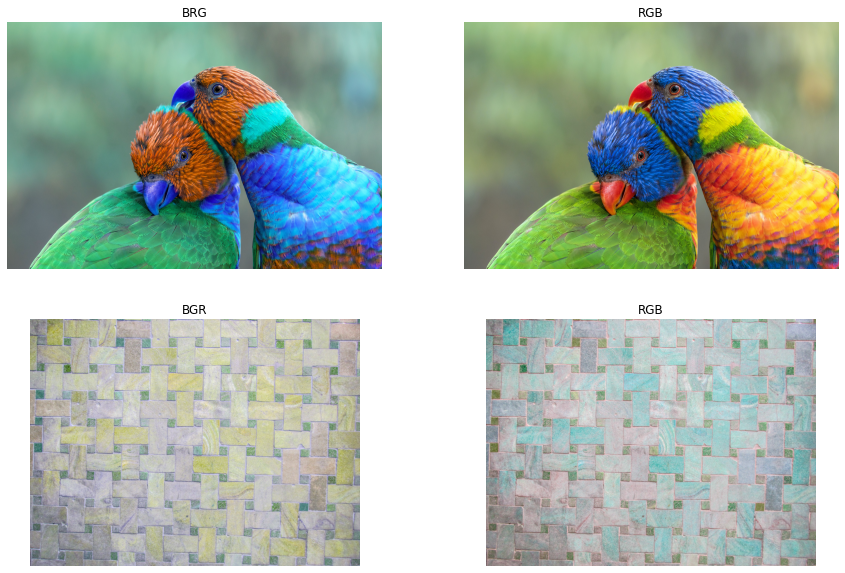

In [9]:
from ex_1 import rgb2hsi, rgb2hsv

img1_bgr = cv2.imread('images/birds.jpg')
img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_bgr = cv2.imread('images/stone.jpg')
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

display([img1_bgr, img1_rgb, img2_bgr, img2_rgb], ['BRG', 'RGB', 'BGR', 'RGB'])

The **RGB** colour space uses three values in the range $\{0 - 255\}$ for the primary colours; **red**, **green**, and **blue**, which are additively combined into the final colour.  Alternatively **HSV/HSI** use the combination of a **hue** (a $360^{\circ}$ that rotates through all of the visible colours), a level of colour **saturation**, and the **value** or **intensity** respectively

To convert from RGB to HSV, the following set of formulae can be used ([1](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv)):

**Value:**
$$ 
\begin{equation}
V = max(R, G, B)
\end{equation} 
$$
**Saturation:**
$$
\begin{matrix}
 S_v= & \frac{V - min(R,G,B)}{V} &\text{  if } V \neq 0  \\
  & 0 &\text{otherwise}
\end{matrix}
$$
**Hue:**
$$:
\begin{matrix}
      & \frac{60 \cdot (G - B)}{V - min(R,G,B)} & \text{  if } V = R  \\
 H =  & \frac{120 + 60 \cdot (B - R)}{V - min(R,G,B)} & \text{  if } V = G  \\
      & \frac{240 + 60 \cdot (R - G)}{V - min(R,G,B)} & \text{  if } V = B  \\
      & 0 & \text{ if } R = B = G
\end{matrix}
$$

**N.B.** $S_v$ represents the saturation for HSV colour space 

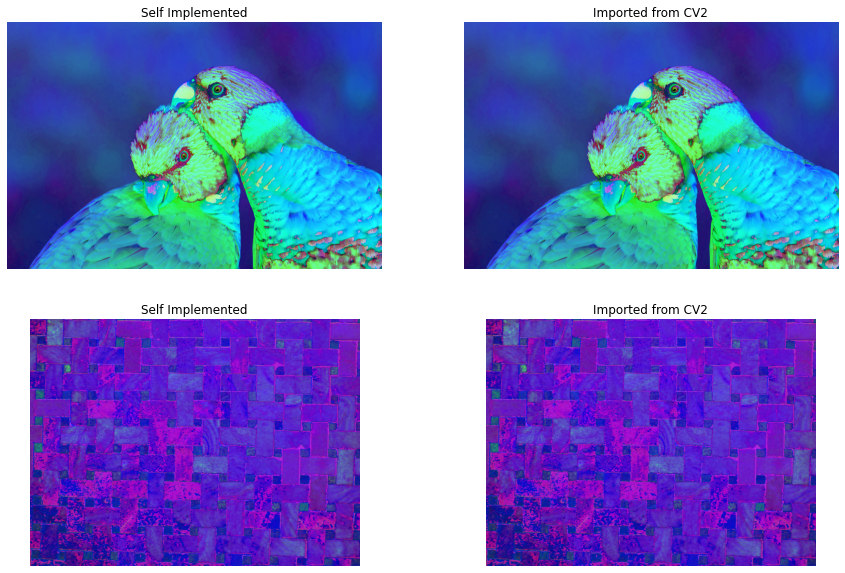

In [13]:
img1_imp_hsv = rgb2hsv(img1_rgb)
img1_cv2_hsv = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2HSV)
img2_imp_hsv = rgb2hsv(img2_rgb)
img2_cv2_hsv = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2HSV)

display([img1_imp_hsv, img1_cv2_hsv, img2_imp_hsv, img2_cv2_hsv], 
        ['Self Implemented', 'Imported from CV2', 'Self Implemented', 'Imported from CV2'])

Each of the images rendered in HSV shows clearly the difference in chroma that initially were difficult to distinguish.  This is particularly clear on the second image, a faded stone in pastle blue and pink.  The low intensity of the RGB image makes the colours seem to fade together to the human eye.  In the HSV space, as the chroma and value are encoded on seperate channels, the red areas indicate a clear colour change, while the blue areas of the image show the value (or lightness) of the image. 

Given the lack of almost any green in the second set of images, we can discern that the image is incredibly faded with a very low level of saturation encoded into the green channel of RGB.  The image of the birds, showing vibrant colours in a very high intensity in the foreground displays the greens expected of a highly saturated image.

### b. RGB to HSI

The HSV and HSI models both use the same value for Hue as calculated in the formula above.  The saturation differs as shown below for the HSI model, with intensity replacing value:

**Intensity**

$$
\begin{equation}
    I = \frac{V_{max} + V_{min}}{2}
\end{equation}
$$

**Saturation**

$$
\begin{matrix}
 S_i= & \frac{V_{max} - V_{min}}{V_{max} + V_{min}}       & \text{ if} I \gt 0.5 \\
      & \frac{V_{max} - V_{min}}{2 - (V_{max} + V_{min})} & \text{ if} I \le 0.5   
\end{matrix}
$$

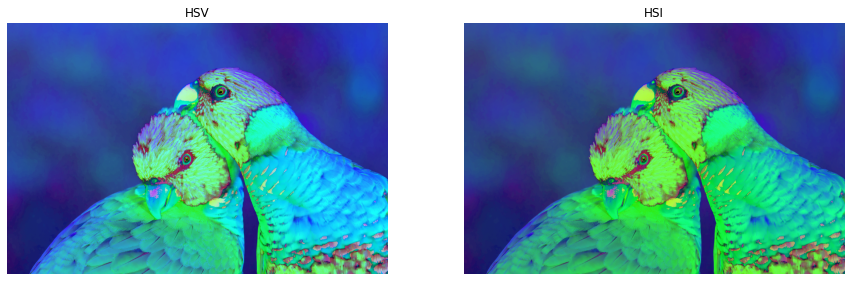

In [18]:
img1_imp_hsi = rgb2hsi(img1_rgb)

display([img1_imp_hsv, img1_imp_hsi], ['HSV', 'HSI'])

Observe that the HSI image more clearly identifies the areas of high saturation in areas of the image. This can be intuitively understood by contrasting the saturation calculations for HSV and HSI against eachother. 

**HSV:**
$$
\begin{matrix}
 S_v= & \frac{V - min(R,G,B)}{V} &\text{  if } V \neq 0  \\
  & 0 &\text{otherwise}
\end{matrix}
$$

**HSI**
$$
\begin{matrix}
 S_i= & \frac{V_{max} - V_{min}}{V_{max} + V_{min}}       & \text{ if} I \lt 0.5 \\
      & \frac{V_{max} - V_{min}}{2 - (V_{max} + V_{min})} & \text{ if} I \ge 0.5   
\end{matrix}
$$

HSV takes the minimum value of the three RGB channels from the total value and then normalises by the value (if not equal to zero).  As $V=max(R, G, B)$ this essentially takes the highest to lowest value range and scales it by the max value.  For a deep RGB blue (10, 20, 255) this would give a saturation value of 0.96 while in the HSI colour space this would be 1 as the largest difference is scaled by the total of the min and max values; thus RGB to HSI conversion highlights saturation more clearly.

## Exercise 2 - Pointwise Transforms & Histogram Equalisation

### References

1. Open Source Computer Vision documentation: https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv
